In [1]:
import pandas as pd
import gzip
import json
import matplotlib.pyplot as plt
import numpy as np

import nltk
from nltk.corpus import stopwords
import re

from sklearn.feature_extraction.text import TfidfVectorizer

stopset = set(stopwords.words('english'))

In [2]:
def parse(path):
    f = open(path, 'rb')
    for l in f:
        yield json.loads(l)

def getDF(path):
    i = 0
    df = {}
    for d in parse(path):
        df[i] = d
        i += 1
    return pd.DataFrame.from_dict(df, orient='index')

df = getDF('Luxury_Beauty_5.json')
meta_df = getDF('meta_Luxury_Beauty.json')

In [3]:
print(len(df))
df.head()

34278


,overall,verified,reviewTime,reviewerID,asin,style,reviewerName,reviewText,summary,unixReviewTime,vote,image
0,5.0,True,"01 5, 2018",A2HOI48JK8838M,B00004U9V2,{'Size:': ' 0.9 oz.'},DB,This handcream has a beautiful fragrance. It d...,Beautiful Fragrance,1515110400,NaN,NaN
1,5.0,True,"04 5, 2017",A1YIPEY7HX73S7,B00004U9V2,{'Size:': ' 3.5 oz.'},Ajaey,"wonderful hand lotion, for seriously dry skin,...",wonderful hand lotion,1491350400,NaN,NaN
2,5.0,True,"03 27, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 250 g'},D. Jones,"Best hand cream around. Silky, thick, soaks i...",Best hand cream around,1490572800,NaN,NaN
3,5.0,True,"03 20, 2017",A2R4UNHFJBA6PY,B00004U9V2,{'Size:': ' 3.5 oz.'},Amazon Customer,Thanks!!,Five Stars,1489968000,NaN,NaN
4,5.0,True,"02 28, 2017",A2QCGHIJ2TCLVP,B00004U9V2,{'Size:': ' 0.9 oz.'},D. Jones,Great hand lotion. Soaks right in and leaves ...,Great hand lotion!,1488240000,NaN,NaN


In [4]:
meta_df.head()

,description,title,also_buy,image,rank,also_view,details,main_cat,price,asin,brand,feature
0,[After a long day of handling thorny situation...,Crabtree & Evelyn - Gardener's Ultra-Moisturis...,"[B00GHX7H0A, B00FRERO7G, B00R68QXCS, B000Z65AZ...",[https://images-na.ssl-images-amazon.com/image...,"4,324inBeautyPersonalCare(","[B00FRERO7G, B00GHX7H0A, B07GFHJRMX, B00TJ3NBN...","\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$30.00,B00004U9V2,NaN,NaN
1,[If you haven't experienced the pleasures of b...,AHAVA Bath Salts,NaN,NaN,"1,633,549inBeautyPersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,NaN,B0000531EN,NaN,NaN
2,"[Rich, black mineral mud, harvested from the b...","AHAVA Dead Sea Mineral Mud, 8.5 oz, Pack of 4",NaN,[https://images-na.ssl-images-amazon.com/image...,"1,806,710inBeautyamp;PersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,NaN,B0000532JH,NaN,NaN
3,[This liquid soap with convenient pump dispens...,"Crabtree & Evelyn Hand Soap, Gardeners, 10.1 f...",NaN,[https://images-na.ssl-images-amazon.com/image...,NaN,"[B00004U9V2, B00GHX7H0A, B00FRERO7G, B00R68QXC...","\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$15.99,B00005A77F,NaN,NaN
4,[Remember why you love your favorite blanket? ...,Soy Milk Hand Crme,"[B000NZT6KM, B001BY229Q, B008J724QY, B0009YGKJ...",[https://images-na.ssl-images-amazon.com/image...,"42,464inBeautyamp;PersonalCare(",NaN,"\n <div class=""content"">\n\n\n\n\n\n\n\n<ul>\...",Luxury Beauty,$18.00,B00005NDTD,NaN,NaN


In [5]:
print(len(set(df['asin'])))
len(set(df['asin']) & set(meta_df['asin']))

1581


1581

### 作るtriplet
- user ->(buy) item
- user ->(mention) feature
- item ->(described_by) feature
- item ->(belong to) brand
- item ->(also_view) item
- item ->(also_buy) item


考えること
- ratingの情報はどうするか。3以上にリンクを残すなど
- priceの情報はどうするか。ある閾値以上にリンクを張るなど.

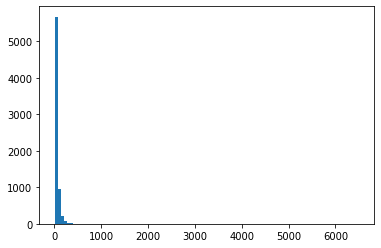

,count,mean,std,min,25%,50%,75%,max
0,6958.0,46.10283,92.443779,1.0,19.5,29.99,52.9975,6500.0


In [17]:
price = []
for p in np.array(meta_df['price']):
    if type(p) != str:
        continue
    try:
        price.append(float(p[1:].replace(',', '')))
    except:
        print(p)
plt.hist(price, bins=100)
plt.show()
pd.DataFrame(pd.Series(price).describe()).transpose()

4分位数等をつかって、priceを四つにランク付けするか?
- priceのノードに辺が集まりすぎる

特別に高価なアイテムだけリンクをつけるなど。2\sigma以上など


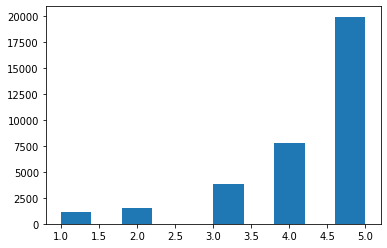

In [301]:
plt.hist(df['overall'])
plt.show()

ratingが1, 2のリンクは消すなど

## 辞書を作る

In [ ]:
user2id = {}
item2id = {}
brand2id = {}
for u in df['reviewerID']:
    if u not in user2id:
        user2id[u] = len(user2id)
        
for item in df['asin']:
    if item not in item2id:
        item2id[item] = len(item2id)
        
for b in meta_df['brand']:
    if b not in brand2id:
        brand2id[b] = len(brand2id)
        
print(user2id)
print(item2id)
print(brand2id)

## reviewとdescriptionからfeatureを取り出す

In [14]:
# 半角記号削除
def del_kigou(text):
    text = re.sub(r'[0-9!-/:-@¥[-`{-~]*', "", text)
    return text

In [7]:
stemmed = []

lemmatizer = nltk.stem.WordNetLemmatizer()
stemmer = nltk.stem.PorterStemmer()

rev = []

for r in list(df['reviewText']):
    if type(r) != str:
        continue
    rev.append(r)
    
for r in list(meta_df['description']):
    if type(r) != list:
        continue
    rev.append(r[0])


In [15]:
# 名詞のみ
corpus = []
nouns_tag = ['NN', 'NNS', 'NNP', 'NNPS']

for text in rev[0:1000]:
    text = del_kigou(text)
    tagged = nltk.pos_tag(text.lower().split())
    
    nouns = ''
    for w, tag in tagged:
        if w in stopset:
            continue
        if tag in nouns_tag:
            # 語幹化
            w = lemmatizer.lemmatize(w)
            #w = stemmer.stem(w)
            nouns += ' ' + w
            
    corpus.append(nouns)

In [10]:
# 単語の頻度を返す
def get_word_freq(corpus):
    word_freq = {}
    for text in corpus:
        for w in text.split(' '):
            if w not in word_freq:
                word_freq[w] = 1
            else:
                word_freq[w] += 1
    return word_freq

In [11]:
word_freq = get_word_freq(corpus)
tfidf_trans = TfidfVectorizer()
tfidf = tfidf_trans.fit_transform(corpus)
feat_words = tfidf_trans.get_feature_names()

In [13]:
len(feat_words)

2295

あるrecordにおいて(dfの行)、tfidfがある閾値以上かつ単語の頻度がある閾値以下のときに、uesrがその単語にmentionしているとする

## Tripletを作る

In [305]:
# user ->(buy) item
user_item_df = pd.concat([df['reviewerID'], df['asin']], axis=1)
user_item_df.to_csv('user_item.csv', index=False)

In [306]:
item_set = set(df['asin'])

In [307]:
# item ->(belong_to) brand
item_brand_df = pd.concat([meta_df['asin'], meta_df['brand']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_brand_df.drop(del_idx)

item_brand_df.to_csv('item_brand.csv', index=False)


In [308]:
# item ->(also_view) item
item_view_item_df = pd.concat([meta_df['asin'], meta_df['also_view']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_view_item_df.drop(del_idx)

item_view_item_df.to_csv('item_view_item.csv', index=False)

In [309]:
# item ->(also_buy) item
item_buy_item_df = pd.concat([meta_df['asin'], meta_df['also_buy']], axis=1)

del_idx = []
for i in range(len(meta_df)):
    if meta_df['asin'][i] not in item_set:
        del_idx.append(i)

item_buy_item_df.drop(del_idx)

item_buy_item_df.to_csv('item_buy_item.csv', index=False)

In [272]:
# user ->(mention) item
thre_thidf = 0.2
thre_freq = 100

In [16]:
print(tfidf)

  (0, 1854)	0.4880324802554905
  (0, 951)	0.3403177296309513
  (0, 852)	0.4057569517648583
  (0, 952)	0.6938079252999344
  (1, 184)	0.3118891696557429
  (1, 1759)	0.36712462784348177
  (1, 2215)	0.2921634918425743
  (1, 2082)	0.30234218626161524
  (1, 1944)	0.45331722877652486
  (1, 1856)	0.22138657314327106
  (1, 1216)	0.4707881075667177
  (1, 951)	0.3391524480571183
  (2, 1884)	0.6126503505988063
  (2, 521)	0.31712001102728626
  (2, 2215)	0.2863851208295534
  (2, 951)	0.6648894713293749
  (3, 2057)	1.0
  (4, 1884)	0.673151603612957
  (4, 1759)	0.39540141722074795
  (4, 1216)	0.5070492983159838
  (4, 951)	0.3652747553423271
  (5, 1870)	0.6661499467397057
  (5, 930)	0.5586866273467649
  (5, 633)	0.44766592214864476
  (5, 1612)	0.20906631251683702
  :	:
  (997, 1856)	0.10625794076311504
  (998, 1930)	0.28654888444704474
  (998, 1298)	0.3134416327400452
  (998, 1326)	0.2532391868676179
  (998, 2260)	0.3134416327400452
  (998, 1327)	0.3900787061429222
  (998, 1236)	0.13991631657681775
  (

In [282]:
i = 0
for w in tfidf:
    print(w)
    if i > 1: break
    i += 1


  (0, 5327)	0.49007565633075695
  (0, 550)	0.34269184164761174
  (0, 2286)	0.49007565633075695
  (0, 1489)	0.2595233622077852
  (0, 47)	0.29700178176009323
  (0, 366)	0.44289293609535224
  (0, 2471)	0.2247163035221493
  (0, 2031)	0.5387974197002788
  (0, 260)	0.6382670787324727
  (0, 550)	0.5498294978724196


In [286]:
print(tfidf[1])

  (0, 5327)	0.49007565633075695
  (0, 550)	0.34269184164761174
  (0, 2286)	0.49007565633075695
  (0, 1489)	0.2595233622077852
  (0, 47)	0.29700178176009323
  (0, 366)	0.44289293609535224
  (0, 2471)	0.2247163035221493
